In [1]:
!rm -rf *
!git clone https://github.com/ALotov2000/mri-classification-cnn
!ln -s mri-classification-cnn/dataset dataset

Cloning into 'mri-classification-cnn'...
remote: Enumerating objects: 1300, done.
remote: Counting objects: 100% (1300/1300), done.
remote: Compressing objects: 100% (1297/1297), done.
remote: Total 1300 (delta 1), reused 1300 (delta 1), pack-reused 0
Receiving objects: 100% (1300/1300), 25.09 MiB | 30.74 MiB/s, done.
Resolving deltas: 100% (1/1), done.


# MRI Classification
*by Ali Lotfollahi*

## Libraries

In [2]:
import os

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np

## Parameters

In [3]:
DATA_LOCATION = 'dataset'
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
BATCH_SIZE = 8

LEARNING_RATE = 0.0001

### Cuda

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def load_data(self):
        data = []
        for i, class_dir in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_dir)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                data.append((file_path, i))
        return data

## Setting up DataLoader

In [6]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    # lambda img: img.expand(3, -1, -1),
    transforms.Normalize(0, 1),
    # transforms.Normalize((0, 0, 0), (1, 1, 1))
])

dataset = CustomDataset(root_dir=DATA_LOCATION, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

### Classes

In [7]:
classes = dataset.classes

### Initial Shape

In [8]:
image, _ = next(iter(dataset))
image.shape

torch.Size([1, 512, 512])

### Examples

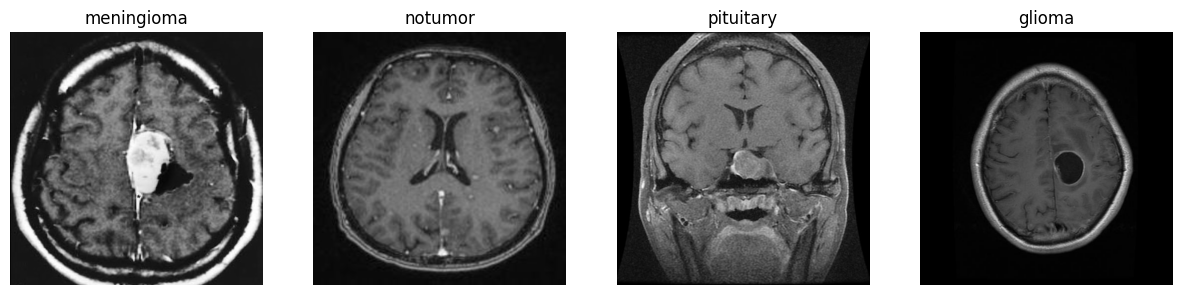

In [9]:
one_image_per_class = {}
for data, target in data_loader:
    if classes[target] not in one_image_per_class:
        one_image_per_class[classes[target]] = data.squeeze()
        if len(one_image_per_class) == len(classes):
            break

fig, axes = plt.subplots(nrows=1, ncols=len(classes))
fig.set_size_inches(15, 5)
for i, (class_name, image) in enumerate(one_image_per_class.items()):
    ax = axes[i]

    image_grid = make_grid(image)
    ax.imshow(image_grid.permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
    ax.set_title(class_name)
plt.show()

## Breaking Data into Train and Test Sets

In [10]:
train_size = int(TRAIN_RATIO * len(dataset))
val_size = int(VAL_RATIO * len(dataset))
test_size = len(dataset) - train_size - val_size

train_size, val_size, test_size

(1048, 131, 132)

In [11]:
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

### Visualization

In [12]:
train_class_names = []
val_class_names = []
test_class_names = []
for _, target in train_set:
    train_class_names.append(classes[target])
for _, target in val_set:
    val_class_names.append(classes[target])
for _, target in test_set:
    test_class_names.append(classes[target])

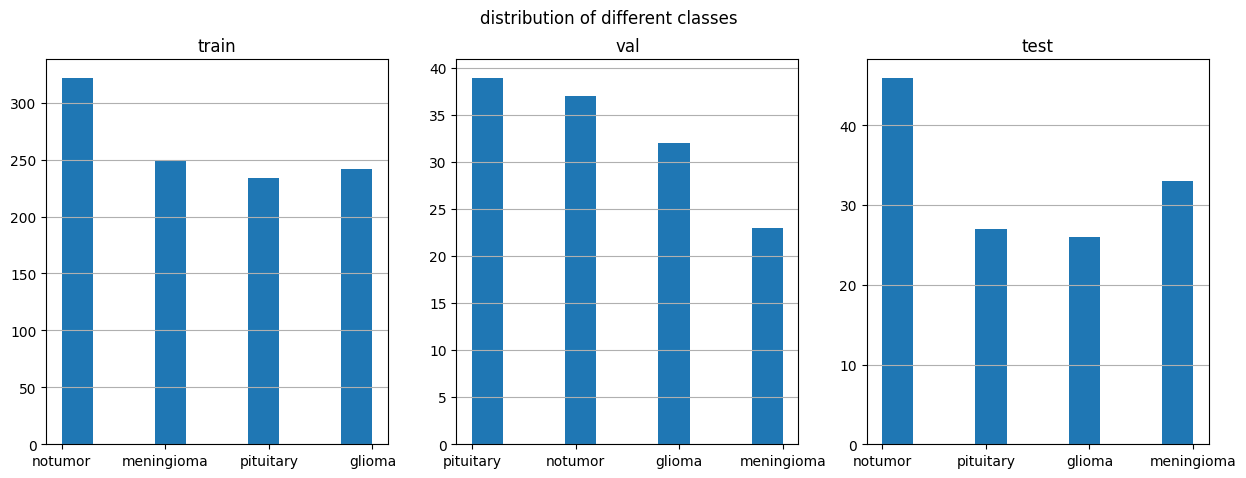

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 5)
fig.suptitle('distribution of different classes')
cols = ['train', 'val', 'test']
for i, col in enumerate(cols):
    axes[i].hist(eval(f"{col}_class_names"))
    axes[i].set_title(col)
    axes[i].grid(axis='y')
plt.show()

## Design of the CNN

In [14]:
print(f"Number of batches in the training set: {int(train_size / BATCH_SIZE)}")
print(f"Number of batches in the validation set: {int(val_size / BATCH_SIZE)}")
print(f"Number of batches in the testing set: {int(test_size / BATCH_SIZE)}")

Number of batches in the training set: 131
Number of batches in the validation set: 16
Number of batches in the testing set: 16


In [15]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [16]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = []

        n_conv = 7
        in_channels =   [1, 64, 128, 256, 512, 1024, 2048]
        out_channels =  [64, 128, 256, 512, 1024, 2048, 4096]
        dim = 512
        for i in range(n_conv):
            exec(f"self.conv{i + 1} = nn.Conv2d(in_channels=in_channels[i], out_channels=out_channels[i], kernel_size=3)")
            self.layers.append(('conv', eval(f"self.conv{i + 1}")))
            dim -= 3 - 1

            exec(f"self.pool{i + 1} = nn.MaxPool2d(kernel_size=2, stride=2)")
            self.layers.append(('pool', eval(f"self.pool{i + 1}")))
            dim //= 2

        self.flatten = nn.Flatten()
        self.layers.append(('flatten', self.flatten))

        n_fc = 2
        in_features =   [out_channels[-1] * dim * dim,  1024]
        out_features =  [1024,                          1024]
        for i in range(n_fc):
            exec(f"self.fc{i + 1} = nn.Linear(in_features=in_features[i], out_features=out_features[i])")
            self.layers.append(('fc', eval(f"self.fc{i + 1}")))
            if i == n_fc - 1:
                continue
            exec(f"self.drop{i + 1} = nn.Dropout(p=0.3)")
            self.layers.append(('drop', eval(f"self.drop{i + 1}")))

        self.out = nn.Linear(in_features=out_features[-1], out_features=len(classes))
        self.layers.append(('out', self.out))

    def forward(self, x):
        for type, layer in self.layers:
            x = layer(x)
            if type == 'conv' or type == 'fc':
                x = F.relu(x)
        return x

**Note:** There is a specific reason for each layer to be there:
- `Conv2d` to reduce number of channels while adding to each kernel's information vector.
- `Pool2d` is specifically used for sampling `Conv2d` output channels.
- `Flatten` to literally flatten the output vector of the reduction step including `Conv2d` layers and `Pool2d` ones.
- `Linear` layers to reduce the number of extracted features until the number of features is appropriate.
- `Dropout` layers also are used to prevent *overfitting* by dropping some features(turning them to zero) by the chance of `p`

**Note:** In Each Layers:

$$ output\_size = \frac{input\_size - kernel\_size + 2 \times padding\_size}{stride} + 1$$

### Instantiation

In [17]:
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1))
  (pool6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(2048, 4096, kernel_size=(3, 3), stride=(1, 1))
  (pool7): MaxPool2d(kernel_size=2, s

In [18]:
n_params = 0
for param in cnn.parameters():
    n_params += len(torch.flatten(param))
print(f"Number of parameters in the model: {n_params:,}")

Number of parameters in the model: 118,479,364


In [19]:
for i, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'inputs shape: {inputs.shape}')
    outputs = cnn(inputs)
    print(f'after network shape: {cnn(inputs).shape}')
    print(outputs[0])
    break

inputs shape: torch.Size([8, 1, 512, 512])
after network shape: torch.Size([8, 4])
tensor([0.0214, 0.0160, 0.0077, 0.0098], device='cuda:0',
       grad_fn=<SelectBackward0>)


### Loss Function

#### Mean Squared Error

$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_{true} - y_{pred.})^2$$

#### Mean Absolute Error

$$MAE = \frac{1}{N}\sum_{i=1}^{N}|y_{true} - y_{pred.}|$$

#### Cross-Entropy Loss

$$\text{Cross-Entropy Loss} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C} y_{true, j}.log(y_{pred., j}),$$
where C is the number of categories and j is the index of each one.

### Optimizer

#### Gradient Discend

$$\theta \leftarrow \theta - \alpha . \nabla J(\theta)$$

#### Adam (Adaptive Moment Estimation)

The difference between Gradient Descend and Adam is in the fact that Adam not only updates the first momentum but also it updates the second one as well:
- $m \leftarrow \beta_1.m + (1 - \beta_1).\nabla J(\theta)$
- $v \leftarrow \beta_2.v + (1 - \beta_2).(\nabla J(\theta))^2$

where $\beta_1$ and $\beta_2$ are decaying rates.

Next, we define:

- $\hat{m} := \frac{m}{1 - \beta_1^t}$
- $\hat{v} := \frac{v}{1 - \beta_2^t}$

where $t$ is the time step (epoch_index).

Thereafter, at last, the new $\theta$ will be computed.

$$\theta \leftarrow \theta - \alpha . \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon }$$

where $\alpha$ is the learning rate and $\epsilon$ is a constant to avoid division by zero

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

### Training

In [21]:
def train_one_epoch():
    cnn.train(True)

    running_loss = 0.
    running_accuracy = 0.

    for batch_index, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = cnn(inputs) # shape: [batch_size, #classes]

        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()

        running_accuracy += correct / BATCH_SIZE

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 20 == 19: # every 20 batches
            avg_loss_across_batches = running_loss / 20
            avg_acc_across_batches = (running_accuracy / 20) * 100
            print(f"Batch: {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}, Accuracy: {avg_acc_across_batches:.1f}%")

            running_loss = 0.
            running_accuracy = 0.

    print()

In [22]:
def validate_one_epoch():
    cnn.train(False)

    running_loss = 0.
    running_accuracy = 0.

    for batch_index, data in enumerate(val_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = cnn(inputs) # shape: [batch_size, #classes]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()

            running_accuracy += correct / BATCH_SIZE

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(val_loader)
    avg_acc_across_batches = (running_accuracy / len(val_loader)) * 100
    print(f"Validation Loss: {avg_loss_across_batches:.3f}, Validation Accuracy: {avg_acc_across_batches:.1f}%")

    print('*' * 50)
    print()

In [23]:
n_epochs = 20

for epoch_index in range(n_epochs):
    print(f"Epoch: {epoch_index + 1}\n")

    train_one_epoch()
    validate_one_epoch()

print('Training Finished!')

Epoch: 1

Batch: 20, Loss: 1.386, Accuracy: 25.0%
Batch: 40, Loss: 1.379, Accuracy: 30.6%
Batch: 60, Loss: 1.252, Accuracy: 31.9%
Batch: 80, Loss: 1.370, Accuracy: 21.9%
Batch: 100, Loss: 1.269, Accuracy: 27.5%
Batch: 120, Loss: 1.207, Accuracy: 41.9%

Validation Loss: 1.204, Validation Accuracy: 40.4%
**************************************************

Epoch: 2

Batch: 20, Loss: 1.118, Accuracy: 51.9%
Batch: 40, Loss: 1.177, Accuracy: 46.9%
Batch: 60, Loss: 1.149, Accuracy: 41.9%
Batch: 80, Loss: 1.051, Accuracy: 45.6%
Batch: 100, Loss: 1.217, Accuracy: 40.6%
Batch: 120, Loss: 1.220, Accuracy: 38.1%

Validation Loss: 1.151, Validation Accuracy: 41.9%
**************************************************

Epoch: 3

Batch: 20, Loss: 1.000, Accuracy: 51.9%
Batch: 40, Loss: 1.187, Accuracy: 46.2%
Batch: 60, Loss: 1.218, Accuracy: 50.0%
Batch: 80, Loss: 1.129, Accuracy: 45.0%
Batch: 100, Loss: 1.090, Accuracy: 50.0%
Batch: 120, Loss: 1.117, Accuracy: 38.8%

Validation Loss: 1.118, Validation 

### Testing

In [24]:
def test():
    cnn.train(False)

    confusion_matrix = np.zeros((len(classes), len(classes)))
    for batch_index, data in enumerate(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels

        batch_size = len(labels)

        with torch.no_grad():
            outputs = cnn(inputs) # shape: [batch_size, #classes]
            preds = torch.argmax(outputs, dim=1)

        for i in range(batch_size):
            confusion_matrix[labels[i], preds[i]] += 1

    return confusion_matrix

In [25]:
confusion_matrix = test()
confusion_matrix

array([[26.,  0.,  1.,  0.],
       [ 0., 44.,  2.,  0.],
       [ 3.,  6., 23.,  1.],
       [ 3.,  1.,  3., 19.]])

#### Accuracy

In [26]:
test_accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
test_accuracy

0.8484848484848485

#### Precision

In [27]:
test_precision = np.zeros(len(classes))
for i in range(len(classes)):
    if np.sum(confusion_matrix[:, i]) == 0:
        test_precision[i] = np.nan
    else:
        test_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])

test_precision

array([0.8125    , 0.8627451 , 0.79310345, 0.95      ])

In [28]:
average_precision = np.average(test_precision[~np.isnan(test_precision)])
average_precision

0.8545871365787694

#### Recall

In [29]:
test_recall = np.zeros(len(classes))
for i in range(len(classes)):
    if np.sum(confusion_matrix[i, :]) == 0:
        test_recall[i] = np.nan
    else:
        test_recall[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])

test_recall

array([0.96296296, 0.95652174, 0.6969697 , 0.73076923])

In [30]:
average_recall = np.average(test_recall[~np.isnan(test_recall)])
average_recall

0.8368059074580814

#### F1 Score

In [31]:
d = (test_precision * test_recall != 0)

test_f1 = np.empty(len(classes))
test_f1.fill(np.nan)
test_f1[d] = 2 * (test_precision[d] * test_recall[d]) / (test_precision[d] + test_recall[d])

test_f1

array([0.88135593, 0.90721649, 0.74193548, 0.82608696])

In [32]:
total_f1 = 2 * (average_precision * average_recall) / (average_precision + average_recall)
total_f1

0.8456030570162614